# The Portrayal of Actresses - What types of women are portrayed in movies?

In [72]:
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import requests
from bs4 import BeautifulSoup as bs
import re
import gender_guesser.detector as gender
import plotly.express as px
import statsmodels.api as sm
import statsmodels.formula.api as smf
from tqdm import tqdm
import plotly.graph_objects as go
from scipy.stats import bootstrap
import hashlib

%matplotlib inline

In [73]:
data_folder = 'data/'
pickle_folder = data_folder + 'pickles/'

In [74]:
characters = pickle.load(open(pickle_folder + 'characters.p', 'rb'))
movies = pickle.load(open(pickle_folder + 'movies.p', 'rb'))

In [75]:
def plot_percentage_number_per_year(df, title, year, *args):
    df = df.loc[df[year].notna()]
    figure, ax = plt.subplots(1,2,figsize=(10,5))
    plt.suptitle(title)

    colours = sns.color_palette(n_colors=len(args) + 1)
    df_percentage = pd.DataFrame()
    df_abs = pd.DataFrame()
    df_abs['total_per_year'] = df[year].value_counts()

    for element in args:
        df_abs[element] = df.loc[df[element].notna()][year].value_counts().astype(float)
        df_percentage[element] = df_abs[element] / df_abs['total_per_year']
    df_abs.index = df_abs.index.astype(float)
    df_percentage.index = df_percentage.index.astype(float)

    ax1 = sns.lineplot(data=df_abs, ax=ax[0],palette=colours[-len(args)-1:], dashes=False)
    ax2 = sns.lineplot(data=df_percentage, ax=ax[1],palette=colours[-len(args):], dashes=False)
    ax1.set_title('Number of characters with specific feature')
    ax2.set_title('Percentage of characters with specific feature')
    ax1.set_xlabel('Years')
    ax2.set_xlabel('Years')
    ax1.set_ylabel('Number of characters')
    ax2.set_ylabel('Percentage of characters with feature')
    plt.show()

## Completeness of our data

We will briefly analyse the temporal completeness of our data

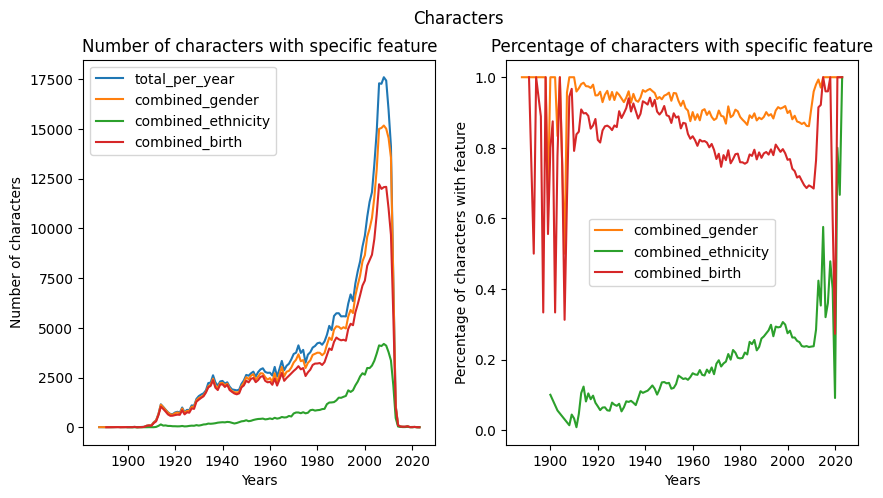

In [76]:
plot_percentage_number_per_year(characters, 'Characters', 'combined_release_year', 'combined_gender', 'combined_ethnicity', 'combined_birth')

Since we want to do an analysis over time, the plot above shows the completeness of actor gender ethnicity and birth over the years. Percentage of characters with specific feature (right graph) gets really noisy at both ends of our year spectrum. This is due to the small amount of movies in those time periods. Overall the gender and birth informations are around 80% complete around all years. Ethnicity on the other hand evolves significantly from older to newer films, and stays at lower completeness levels.

There are 1383 movies that released before 1915 (1.69% of total movies)
There are 1633 movies that released after 2011 (2.00% of total movies)


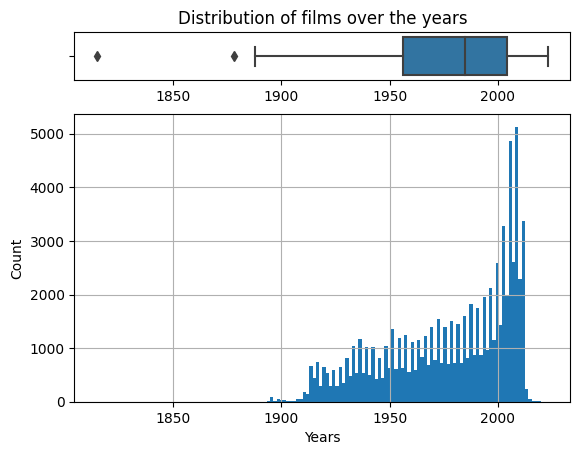

In [77]:
_, ax = plt.subplots(2,1, gridspec_kw={'height_ratios': [1, 6]})
ax1 = sns.boxplot(x = movies["combined_release_year"], ax = ax[0])
ax2 = movies["combined_release_year"].hist(bins = movies["combined_release_year"].nunique(), ax = ax[1])
ax[1].set_ylabel("Count")
ax[1].set_xlabel("Years")

ax[0].set_title("Distribution of films over the years")
ax[0].set_xlabel("")

old_tresh = 1915
young_tresh = 2011

young = len(movies.loc[movies["combined_release_year"] > young_tresh])
young_ratio = (young/len(movies))*100
old = len(movies.loc[movies["combined_release_year"] < old_tresh])
old_ratio = (old/len(movies))*100

print(f"There are {old} movies that released before {old_tresh} ({old_ratio:.2f}% of total movies)\n"
      f"There are {young} movies that released after {young_tresh} ({young_ratio:.2f}% of total movies)")

Here we can see the distribution of films over the years. It is skewed towards more recent years. But there are few films that released before 1915 and after 2011, respectively 1.69% and 2%.

## How are presence and age evolving year by year?
The following analysis will be conducted using the dataset that was created by merging informations coming CMU dataset, IMDB and wikidata.


### Presence of women as actors

In [78]:
male_char = characters.loc[characters["combined_gender"] == "male"]
female_char = characters.loc[characters["combined_gender"] == "female"]
non_bin = characters.loc[(characters["combined_gender"] != "female") & (characters["combined_gender"] != "male") & (characters["combined_gender"]).notna()]
remaining = characters.loc[characters["combined_gender"].isnull()]

unique_male = (male_char["actor_name"].nunique())
unique_female = (female_char["actor_name"].nunique())
unique_non_bin = (non_bin["actor_name"].nunique())
unique_remaining = (remaining["actor_name"].nunique())

print(f"There are {unique_male} male actors in our dataset for a total of {len(male_char)} appearances = an average of {len(male_char)/unique_male:.2f} movies per man \n"
      f"There are {unique_female} female actors in our dataset for a total of {len(female_char)} appearances = an average of {len(female_char)/unique_female:.2f} movies per woman\n"
      f"There are {unique_non_bin} non-binary people in our dataset for a total of {len(non_bin)} appearances\n"
      f"We are missing the gender of {unique_remaining} actors gender infos for a total of {len(remaining)} appearances = an average of {len(remaining)/unique_remaining:.2f} movies per person")

There are 61231 male actors in our dataset for a total of 271200 appearances = an average of 4.43 movies per man 
There are 35950 female actors in our dataset for a total of 135184 appearances = an average of 3.76 movies per woman
There are 50 non-binary people in our dataset for a total of 266 appearances
We are missing the gender of 37221 actors gender infos for a total of 44019 appearances = an average of 1.18 movies per person


For this first analysis we are going to leave out non-binary people out, as they represent a small fraction of our dataset. In order to complete the dataset even more, we could try to infer the gender of actors based on their name, by using gender_guesser package for example. This would of course yield some incorrect results for some of the actors, but overall the accuracy should be good enough. These non-gendered actors seems  to have on average fewer films per actors (1.18), we think its because they are less important actors and that is also why we did not find their gender in our databases.

In addition. we see that the amounts of female and male actors are very different. We have 2 hypothesis to explain this difference:
* There is actually less women in the actors of film industry
* Actresses occupy less important roles, they might not get credited enough and end up not being present in the different datasets we used.

Let's see how this unbalance evolved year by year.

c:\Users\eliot\anaconda3\envs\ADA\lib\site-packages\seaborn\distributions.py:269: FutureWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`



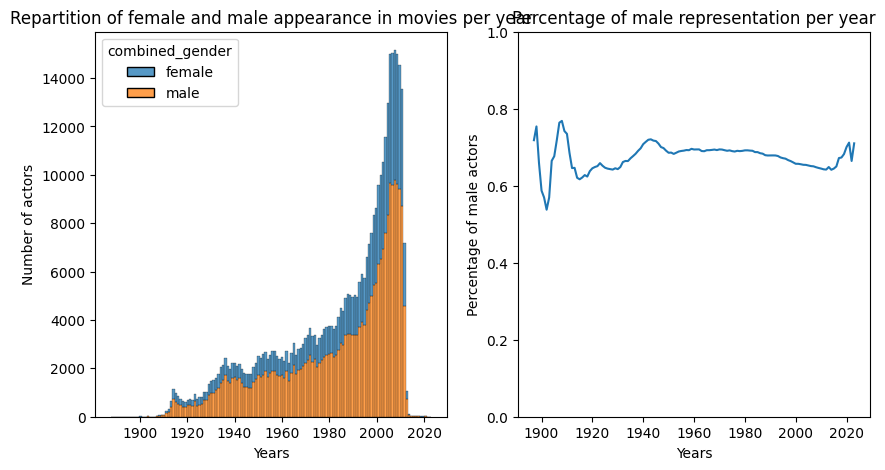

In [79]:
_, ax = plt.subplots(1,2,figsize = (10,5))

df = characters.loc[(characters["combined_gender"] == "female") | (characters["combined_gender"] == "male")]
ax1 = sns.histplot(data=df, stat="count", multiple="stack", x="combined_release_year", hue="combined_gender",ax = ax[0])

def find_ratio(df):
    return len(df.loc[df["combined_gender"] == "male"])/len(df)
male_v_female_repres = df.groupby("combined_release_year").apply(lambda x: find_ratio(x))

ax2 = sns.lineplot(male_v_female_repres.rolling(7).mean().T, ax = ax[1])
ax2.set_ylim([0,1])

ax1.set_title('Repartition of female and male actors appearance in movies per year')
ax2.set_title('Percentage of male representation per year')

ax1.set_xlabel('Years')
ax2.set_xlabel('Years')

ax1.set_ylabel('Number of actors')
ax2.set_ylabel('Percentage of male actors')
plt.show()

In [80]:
val = (len(df.loc[df["combined_gender"] == "male"])/len(df))*100
print(f"The average percentage of men across all the years in the total number of actors is {val:.2f}%")

The average percentage of men across all the years in the total number of actors is 66.73%


We can see from the graph that the percentage of man vs woman is the same across the years, except in the more recent and older films where we have quite a bit of noise, due to the lack of data. It seems that independently of the release year of the film, there are always more male actors that are present, or at least cited, this value stays in the neighborhood of the average 66% without any big jumps, except at both ends of the spectrum, this is again due to the lack of data.

### Actresses' age over the years

first a bit about the completeness of our data

In [81]:
df_births = df.loc[df["combined_birth"].notna()]
df_missing_births = df.loc[df["combined_birth"].isna()]

fn = lambda row: row.combined_release_year - row.combined_birth
col = df_births.apply(fn, axis=1)
df_births = df_births.assign(age=col.values)

unique_birth = df_births["actor_name"].nunique()

print(f"We have {unique_birth} actors who have a male/female gender and an age\n"
      f"this represemts {len(df_births)} entries\n"
      f"we are missing the birthdate of {len(df_missing_births)} male/female actors")

We have 59052 actors who have a male/female gender and an age
this represemts 348564 entries
we are missing the birthdate of 57820 male/female actors


We remove the actors who's age is smaller tham 0 and greater than 100.

In [82]:
df_births = df_births.loc[(df_births["age"] > 0) & (df_births["age"] < 100) ]
df_births = df_births.loc[(df_births["combined_release_year"] > 1909) & (df_births["combined_release_year"] < 2020) ] # we also drop the movies before 1910 and after 2020 since we do not have enough data in those years

Let's look at the overall age difference

In [83]:
df_births

,movie_wiki_id,movie_freebase_id,release_date_cmu,character_name,actor_name,height,birth_cmu,birth_wd,birth_imdb,combined_birth,...,combined_ethnicity,freebase_character_id,freebase_actor_id,wikidata_actor_id,actor_imdb_id,combined_release_year,wikipedia_id,movie_metric,actor_metric,age
0,975900,/m/03vyhn,2001,Akooshay,Wanda De Jesus,1.620,1958.0,1958.0,1958.0,1958.0,...,NaN,/m/0bgcj3x,/m/03wcfv7,Q1873468,nm0208962,2001.0,975900,2.360202,3.680168,43.0
1,975900,/m/03vyhn,2001,Lieutenant Melanie Ballard,Natasha Henstridge,1.780,1974.0,1974.0,1974.0,1974.0,...,NaN,/m/0bgchn4,/m/0346l4,Q230527,nm0000449,2001.0,975900,2.360202,8.613544,27.0
2,975900,/m/03vyhn,2001,Desolation Williams,Ice Cube,1.727,1969.0,1969.0,1969.0,1969.0,...,African Americans,/m/0bgchn_,/m/01vw26l,Q173637,nm0001084,2001.0,975900,2.360202,16.246636,32.0
3,975900,/m/03vyhn,2001,Sgt Jericho Butler,Jason Statham,1.750,1967.0,1967.0,1967.0,1967.0,...,NaN,/m/0bgchnq,/m/034hyc,Q169963,nm0005458,2001.0,975900,2.360202,18.203484,34.0
4,975900,/m/03vyhn,2001,Bashira Kincaid,Clea DuVall,1.650,1977.0,1977.0,1977.0,1977.0,...,NaN,/m/0bgchp9,/m/01y9xg,Q233347,nm0245112,2001.0,975900,2.360202,14.419565,24.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
450661,913762,/m/03pcrp,1992,UN Spacy Commander,Sonny Byrkett,NaN,1954.0,NaN,NaN,1954.0,...,NaN,/m/0kr407_,/m/0gn4bz,NaN,NaN,1992.0,913762,0.010734,0.010734,38.0
450662,913762,/m/03pcrp,1992,Silvie Gena,Susan Byrkett,NaN,1958.0,NaN,NaN,1958.0,...,NaN,/m/0kr40bf,/m/0gn4nd,NaN,NaN,1992.0,913762,0.010734,0.010734,34.0
450664,913762,/m/03pcrp,1992,Elensh,Dorothy Elias-Fahn,NaN,1970.0,1962.0,1962.0,1962.0,...,NaN,/m/0kr406h,/m/0b_vcv,Q5298405,nm0253528,1992.0,913762,0.010734,1.096227,30.0
450665,913762,/m/03pcrp,1992,Hibiki,Jonathan Fahn,NaN,1965.0,1965.0,1965.0,1965.0,...,NaN,/m/0kr4090,/m/0bx7_j,Q3809919,nm0153068,1992.0,913762,0.010734,0.828960,27.0


In [84]:
for i in range(int(df_births.combined_release_year.min()), int(df_births.combined_release_year.max())):
    year_low = i// 10 * 10
    year_high = year_low + 9
    df_births.loc[df_births.combined_release_year == i, 'group_year'] = f"{year_low} - {year_high}"

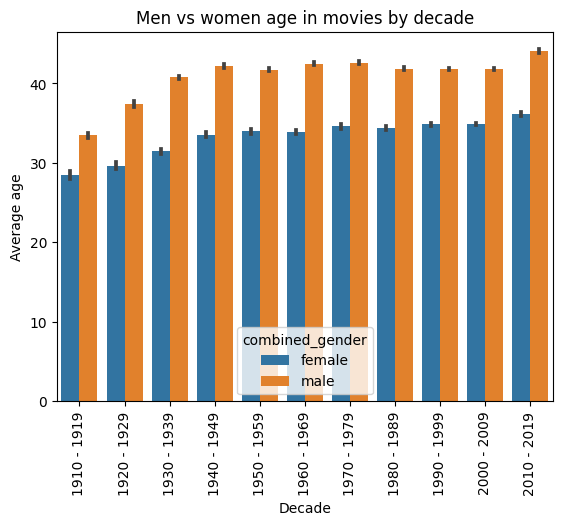

In [85]:
ax = sns.barplot(data = df_births.sort_values(by = "group_year"), x = "group_year", y = "age", hue = "combined_gender")
plt.xticks(rotation = 90)
plt.title("Men vs women age in movies by decade")
ax.set_xlabel("Decade")
ax.set_ylabel("Average age")
plt.show()

In [86]:
avg_men_age = df_births.loc[df_births["combined_gender"]=="male"].groupby("group_year")["age"].mean()
avg_women_age = df_births.loc[df_births["combined_gender"]=="female"].groupby("group_year")["age"].mean()
avg_diff = (avg_men_age - avg_women_age).dropna()

In [87]:
avg_diff = pd.DataFrame(avg_diff).reset_index()

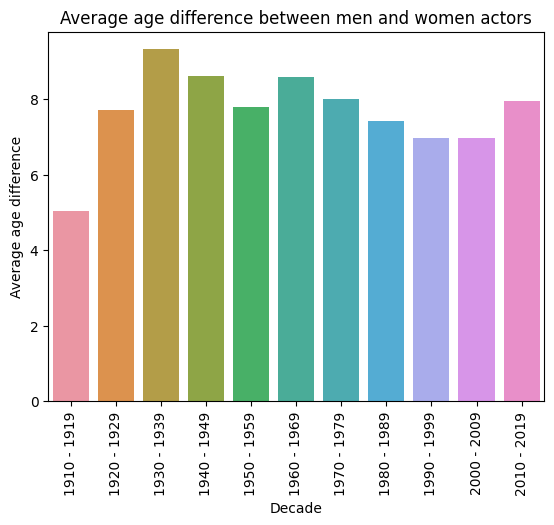

In [88]:
ax = sns.barplot(data = avg_diff, x = "group_year", y = "age")
plt.xticks(rotation = 90)
plt.title("Average age difference between men and women actors")
ax.set_xlabel("Decade")
ax.set_ylabel("Average age difference")
plt.show()

In [89]:
from scipy.stats import ttest_ind, ttest_rel

In [90]:
women_age = df_births.loc[df_births["combined_gender"]=="female"]["age"]
men_age = df_births.loc[df_births["combined_gender"]=="male"]["age"]

print(ttest_ind(women_age, men_age))

mean_f = women_age.mean()
median_f = women_age.median()

mean_m = men_age.mean()
median_m = men_age.median()

diff_mean = mean_m-mean_f
diff_median = median_m-median_f

print(f"The average woman age on screen is {mean_f:.2f} and the average men age is {mean_m:.2f}, for a difference of {diff_mean:.2f} years")

Ttest_indResult(statistic=-151.1593295149693, pvalue=0.0)
The average woman age on screen is 34.29 and the average men age is 41.83, for a difference of 7.54 years


Based on the results opf the t-test, and the p value being of 0, we can say with great confidence that men and female definetly do not have the same age on screen.

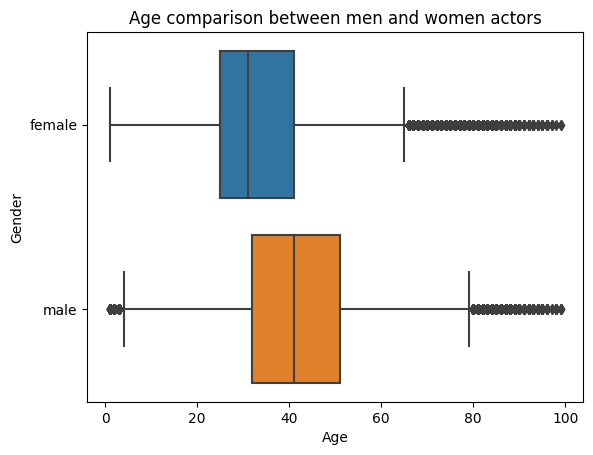

In [91]:
ax = sns.boxplot(data = df_births, x = "age", y = "combined_gender")
plt.title("Age comparison between men and women actors")
ax.set_xlabel("Age")
ax.set_ylabel("Gender")
plt.show()

From the plot above, we can see that there is an overall difference between male and female actors' age. The median age is different and the women's age is skewed towards younger ages (other visualisation in following plots).

In [92]:
births_male = df_births[df_births["combined_gender"] == "male"]
births_female = df_births[df_births["combined_gender"] == "female"]

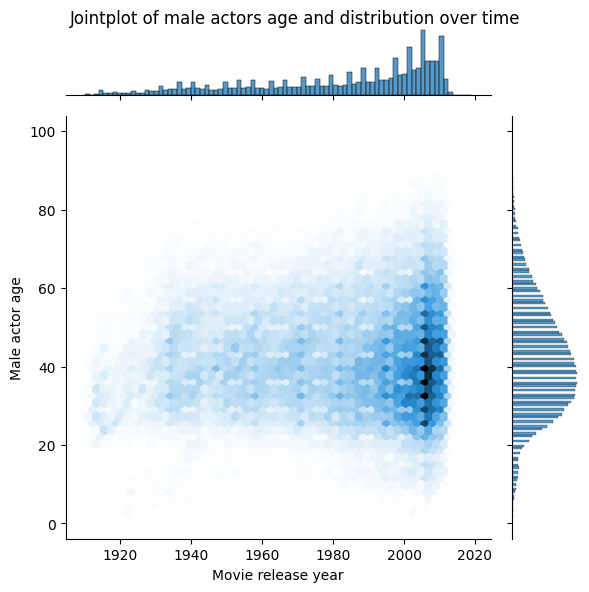

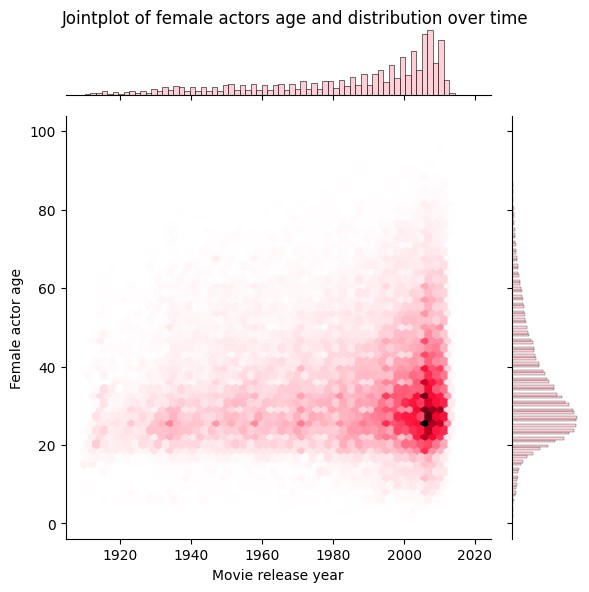

In [93]:
p = sns.jointplot(data=births_male, x = "combined_release_year", y = "age", kind = "hex")
p.fig.suptitle("Jointplot of male actors age and distribution over time")
p.fig.tight_layout()
p.fig.subplots_adjust(top=0.95)

plt.xlabel('Movie release year')
plt.ylabel('Male actor age')

plt.show()

p = sns.jointplot(data=births_female, x = "combined_release_year", y = "age", kind = "hex", color = "pink")
p.fig.suptitle("Jointplot of female actors age and distribution over time")
p.fig.tight_layout()
p.fig.subplots_adjust(top=0.95)

plt.xlabel('Movie release year')
plt.ylabel('Female actor age')

plt.show()

The distribution of women's age seems to be more skewed to towards smaller ages than men. Average men age is more spread out.

Let's see how this difference evolves over time.

In [94]:
avg_men_age = births_male.groupby("combined_release_year")["age"].mean()
avg_women_age = births_female.groupby("combined_release_year")["age"].mean()
avg_diff = (avg_men_age - avg_women_age).dropna()

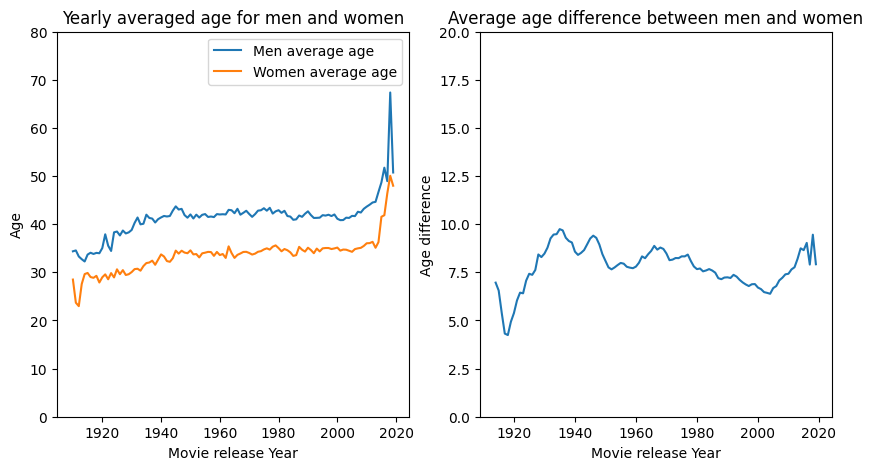

In [95]:
_, ax = plt.subplots(1,2,figsize = (10,5))

ax1 = sns.lineplot(avg_men_age.T, label = "Men average age", ax = ax[0])
ax2 = sns.lineplot(avg_women_age.T, label = "Women average age", ax = ax[0])
ax3 = sns.lineplot(avg_diff.rolling(5).mean().T, ax = ax[1])

ax2.set_ylim([0,80])
ax2.set_title("Yearly averaged age for men and women")
ax2.set_xlabel("Movie release Year")
ax2.set_ylabel("Age")

ax3.set_ylim([0,20])
ax3.set_title("Average age difference between men and women")
ax3.set_xlabel("Movie release Year")
ax3.set_ylabel("Age difference")

plt.show()

Since the noise is really important, we cut the extremes years for better visualisation

In [96]:
min = 1920
max = 2010
avg_men_age = avg_men_age.loc[avg_men_age.index.isin(np.linspace(min,max, num = max-min+1))]
avg_women_age = avg_women_age.loc[avg_women_age.index.isin(np.linspace(min,max, num = max-min+1))]
avg_diff = (avg_men_age - avg_women_age).dropna()

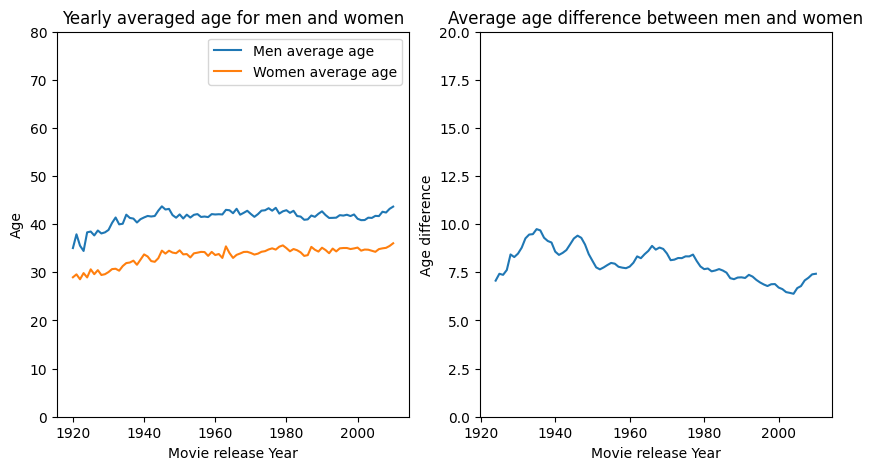

In [97]:
_, ax = plt.subplots(1,2,figsize = (10,5))

ax1 = sns.lineplot(avg_men_age.T, label = "Men average age", ax = ax[0])
ax2 = sns.lineplot(avg_women_age.T, label = "Women average age", ax = ax[0])
ax3 = sns.lineplot(avg_diff.rolling(5).mean().T, ax = ax[1])

ax2.set_ylim([0,80])
ax2.set_title("Yearly averaged age for men and women")
ax2.set_xlabel("Movie release Year")
ax2.set_ylabel("Age")

ax3.set_ylim([0,20])
ax3.set_title("Average age difference between men and women")
ax3.set_xlabel("Movie release Year")
ax3.set_ylabel("Age difference")

plt.show()

Men actors seem to be overall older than women actors, but it looks that the difference gets a bit smaller, when coming closer to the 2000's.

## Actresses and genre

In [98]:
merged_character = pd.merge(characters, movies, left_on='movie_freebase_id', right_on='freebase_id_cmu', how='left')

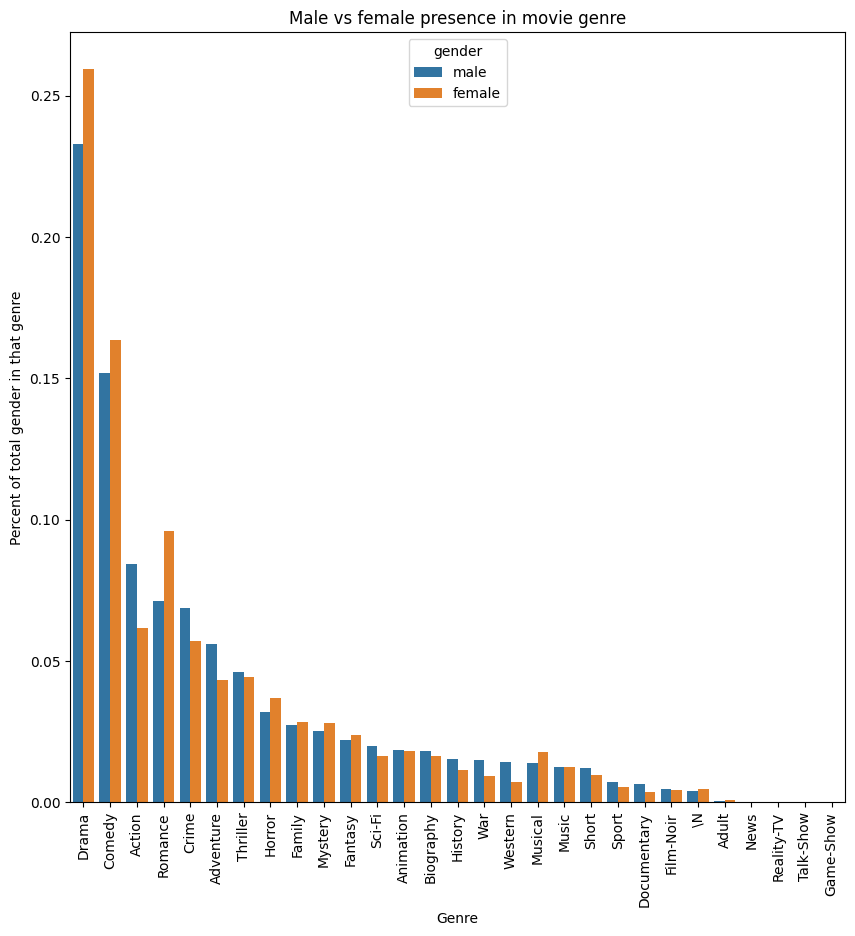

In [99]:
df = pd.DataFrame()
df2 = pd.DataFrame()
df['genre'] = merged_character.loc[merged_character.combined_gender == 'female'].genres_imdb.str.split(',').explode().value_counts() / len(merged_character.loc[merged_character.combined_gender == 'female'].genres_imdb.str.split(',').explode())
df['gender'] = 'female'
df2['genre'] = merged_character.loc[merged_character.combined_gender == 'male'].genres_imdb.str.split(',').explode().value_counts()/ len(merged_character.loc[merged_character.combined_gender == 'male'].genres_imdb.str.split(',').explode())
df2['gender'] = 'male'

df = pd.concat([df2, df])
df = df.reset_index()

fig, ax = plt.subplots(figsize=(10,10))

ax = sns.barplot(data=df, x='index', y='genre', hue='gender')
plt.xticks(rotation=90)
ax.set_title("Male vs female presence in movie genre")
ax.set_xlabel('Genre')
ax.set_ylabel('Percent of total gender in that genre')
plt.show()

This graph shows that women appear more in Drama, Comedy and Romance compared to men, who appear more in Action, Crime and Adventure.

## Are women equally represented in leading and minor roles?

In order to find the presence of women in major/minor roles we are considering their appearance in the credits of a film. The order of the credits can be considered as importance in the film, as first cast members will be the main actors, while following are less important. This order can be found on the "Full Cast & Crew" page of nearly all movies present on IMDB.

In [100]:
print(f"We have the imdb id of {movies.IMDB_id.dropna().count()} movies")

We have the imdb id of 74675 movies


We will get the index of the first woman cited in the credits, and see how this evolves over the years.

In [101]:
d = gender.Detector() #we initialize it outside the multiprocessing to gain time

In [102]:
def find_first_woman_index(gender_list, gender = "female"): #returns the index or nan if there are no women in the credits
    try:
        index_f = (gender_list.index(gender))
    except:
        index_f = np.inf
    try:
        index_mf = (gender_list.index("mostly_"+gender))
    except:
        index_mf = np.inf

    if index_f < index_mf:
        index = index_f
    else:
        index = index_mf

    if index == np.inf:
        index = np.nan

    return index

In [103]:
def get_gender_list(imdb_id, gender = "female"):
    r = requests.get(f"https://www.imdb.com/title/{imdb_id}/fullcredits?ref_=tt_ov_st_sm")
    soup = bs(r.text, 'html.parser')
    table = soup.find('table', class_='cast_list')
    first_name = 'img alt="[\w]+'
    if table is not None:
        m = re.findall(first_name, table.decode())
        gender_list = [d.get_gender(s.replace('img alt="', "")) for s in m] #we find the gender of the person using a gender detector package
        return [imdb_id, find_first_woman_index(gender_list, gender)+1]

    else:
        return [imdb_id, "no-cast"] #if the page does not exist

gender_list gives us the gender of the actors, and the order of the list is the order they appear in the movie's credits.


In [104]:
imdb_id = movies.IMDB_id.dropna()
total_len = len(imdb_id)

#The multiprocessing was run in src/mutliproc.py

Newly scraped data with all movies with imdB id

In [105]:
credit_rank = pd.DataFrame.from_records(pickle.load(open(pickle_folder+"women_appearance.p","rb"))).rename({0:"IMDB_id",1:"women_credit_rank",2:"men_credit_rank"}, axis=1)
credit_rank = credit_rank.loc[(credit_rank["women_credit_rank"] != "no-cast") & (credit_rank["women_credit_rank"].notna()) & (credit_rank["men_credit_rank"].notna()) & (credit_rank["men_credit_rank"] != "no-cast")] #we remove the Nan and the no cast movies

We discard the movies that have none or both rank that is 1 (this means that the gender detector didn't do its job properly) and add a column to precise if the lead is male or female

In [106]:
def f(women_credit_rank, men_credit_rank):
    if (women_credit_rank == 1 and men_credit_rank == 1) or (women_credit_rank != 1 and men_credit_rank != 1): #issue at least on of them should be 1 but not both
        return np.NaN # will be dropped later
    else:
        if women_credit_rank == 1:
            return "female"
        else:
            return  "male"

credit_rank["lead"] = credit_rank.apply(lambda x: f(x.women_credit_rank, x.men_credit_rank), axis = 1)

In [107]:
credit_rank = credit_rank.dropna(subset=["lead"])

we add is_woman_lead that is 1 if the lead is female and 0 otherwise, this will be used to perform the regression later on

In [108]:
def is_lead(lead):
    if lead == "female":
        return 1
    else:
        return 0
credit_rank["is_woman_lead"] = credit_rank.apply(lambda x: is_lead(x.lead), axis = 1)

In [109]:
credit_rank["women_credit_rank"] = credit_rank["women_credit_rank"].astype(float)

In [110]:
merged = (movies.merge(credit_rank, left_on="IMDB_id", right_on="IMDB_id"))
merged = merged.loc[(merged["men_credit_rank"].notna()) & (merged["men_credit_rank"] != "no-cast")]
merged = merged.loc[(merged["combined_release_year"] > 1930) & (merged["combined_release_year"] < 2020)]
merged["group_year"] = ((merged["combined_release_year"]//10)*10).astype(int).astype(str)+"s"

In [111]:
df = pd.DataFrame()
df['appearance'] = merged.women_credit_rank
df['gender'] = 'Female'
df["group_year"] = merged["group_year"]
df2 = pd.DataFrame()
df2['appearance'] = merged.men_credit_rank
df2['gender'] = 'Male'
df2["group_year"] = merged["group_year"]
df_final = pd.concat([df, df2])

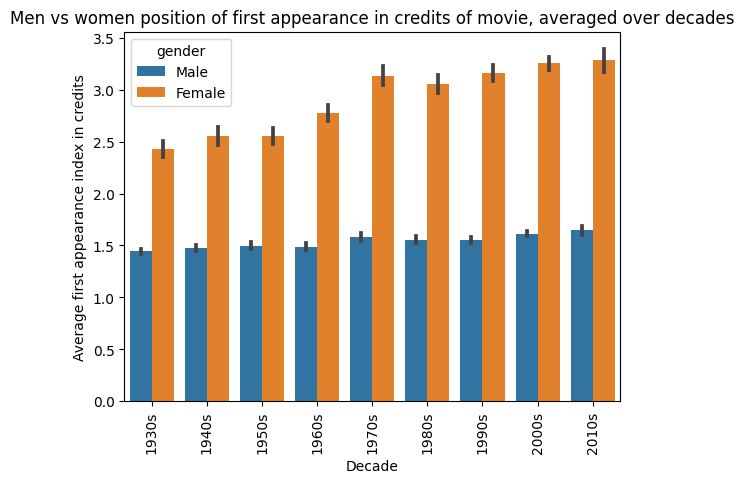

In [112]:
ax = sns.barplot(data = df_final.sort_values(by = "group_year"), x = "group_year", y = "appearance", hue = "gender")
plt.xticks(rotation = 90)
plt.title("Men vs women position of first appearance in credits of movie, averaged over decades")
ax.set_xlabel("Decade")
ax.set_ylabel("Average first appearance index in credits")
plt.show()

We can see that on average women first appearance in the credits is is much later than men.

Confidence interval caluclation for plotly using bootstraping

In [114]:
genders = ["Female","Male"]
decades = ["1930s","1940s","1950s","1960s","1970s","1980s","1990s","2000s","2010s"]

upper_f = []
lower_f = []

g = "Female"
for d in decades:
    #print(df_final.loc[(df_final["gender"] == g) & (df_final["group_year"] == d)]["appearance"].values)
    data = df_final.loc[(df_final["gender"] == g) & (df_final["group_year"] == d)]["appearance"].values.tolist()
    moyenne = np.mean(data)
    data = (data,)
    ci_l, ci_u = bootstrap(data, np.mean).confidence_interval
    lower_f.append(moyenne-ci_l)
    upper_f.append(ci_u-moyenne)

upper_m = []
lower_m = []

g = "Male"
for d in decades:
    #print(df_final.loc[(df_final["gender"] == g) & (df_final["group_year"] == d)]["appearance"].values)
    data = df_final.loc[(df_final["gender"] == g) & (df_final["group_year"] == d)]["appearance"].values.tolist()
    moyenne = np.mean(data)
    data = (data,)
    ci_l, ci_u = bootstrap(data, np.mean).confidence_interval
    lower_m.append(moyenne-ci_l)
    upper_m.append(ci_u-moyenne)


Plotly version of the previous graph

In [115]:
fig = go.Figure()
fig.add_trace(go.Scatter(y=df_final.loc[df_final["gender"] == "Male"].groupby(["group_year"]).mean().values[:].flatten().tolist(), x=decades, name="Male",
                        error_y=dict(type='data', array=upper_m, arrayminus=lower_m)))
fig.add_trace(go.Scatter(y=df_final.loc[df_final["gender"] == "Female"].groupby(["group_year"]).mean().values[:].flatten().tolist(), x=decades, name="Female",
                        error_y=dict(type='data', array=upper_f, arrayminus=lower_f)))

fig.update_layout(title_text='Average First Appearance in The Credits by Gender by Decade')
# axis between 0 and 1
fig.update_yaxes(range=[1, 3.5])
# labels 
fig.update_xaxes(title_text='Decade')
fig.update_yaxes(title_text='Average First Apperance in the credits')

# title of legend
fig.update_layout(legend_title_text='Gender')

fig.show()

# save fig to html
fig.write_html('docs/_includes/first_appearance_per_decade_per_gender.html')

C:\Users\eliot\AppData\Local\Temp\ipykernel_18528\2873739052.py:2: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.

C:\Users\eliot\AppData\Local\Temp\ipykernel_18528\2873739052.py:4: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



# The actors and the impact score

## Percent of female actors

Let's look at how the percentage of female actors in cast can influence the movie impact score

In [116]:
characters_movies = pd.merge(characters[['movie_wiki_id', 'actor_name', 'combined_birth', 'combined_gender']], movies[['wikipedia_id', 'title', 'combined_release_year',  'metric']], left_on='movie_wiki_id', right_on='wikipedia_id', how='left')
characters_movies["age"] = characters_movies["combined_release_year"]-characters_movies["combined_birth"]

### Find the percentage of male and female actors in each movie

In [117]:
new = pd.DataFrame(characters_movies.groupby("title")["combined_gender"].value_counts(normalize=True)).rename(columns={"combined_gender":"percent"})
new = new.reset_index()
newF = new.loc[new["combined_gender"] == "female"].drop(columns=["combined_gender"]).rename(columns={"percent":"f_actor_percentage"})
newM = new.loc[new["combined_gender"] == "male"].drop(columns=["combined_gender"]).rename(columns={"percent":"m_actor_percentage"})
actor_gender_percentage = pd.merge(newF, newM, left_on="title", right_on="title")

In [118]:
gender_stats = pd.merge(movies[["title","metric","genres_imdb","combined_release_year","IMDB_id"]], actor_gender_percentage, left_on="title", right_on="title", how="inner")
gender_stats = gender_stats.dropna()
gender_stats = gender_stats.loc[(gender_stats["combined_release_year"] > 1930) & (gender_stats["combined_release_year"] < 2020)]

### Evolution of the metric over the centuries

In [119]:
gender_stats["century"] = ((gender_stats["combined_release_year"]//100)*100).astype(int).astype(str)+"s"
gender_stats["percent_share"] = ((gender_stats["f_actor_percentage"]*100//10)*10).apply(str)+"-"+(((gender_stats["f_actor_percentage"]*100//10)*10)+10).apply(str)+"%"

In [120]:
def convert(century):
    if century == "2000s":
        return "21st Century"
    else:
        return "Before 21st Century"

In [121]:
gender_stats["century"] = gender_stats["century"].apply(lambda x: convert(x))
gender_stats = gender_stats.sort_values("century")

In [122]:
fig = px.histogram(gender_stats, x="percent_share")
fig.update_xaxes(categoryorder='category ascending')

fig.update_layout(title_text='Number of Movies with Given Percentage of Female Actors in Them')

# labels 
fig.update_xaxes(title_text='Percentage of Women')
fig.update_yaxes(title_text='Number of Movies')

# title of legend
fig.update_layout(legend_title_text='Gender')

fig.show()

# save fig to html
fig.write_html('docs/_includes/histogram_num_movies_perc_female.html')

We see that most films have less than 50% female actors in cast

In [123]:
gender_stats

,title,metric,genres_imdb,combined_release_year,IMDB_id,f_actor_percentage,m_actor_percentage,century,percent_share
0,Ghosts of Mars,2.360202,"Action,Horror,Sci-Fi",2001.0,tt0228333,0.352941,0.647059,21st Century,30.0-40.0%
26128,Kush,-0.646033,"Action,Crime,Thriller",2007.0,tt0477138,0.111111,0.888889,21st Century,10.0-20.0%
26127,The Wild Hunt,0.021394,"Drama,Thriller",2009.0,tt1493886,0.375000,0.625000,21st Century,30.0-40.0%
26122,Derrière les murs,0.054041,"Drama,Horror,Mystery",2011.0,tt1642194,0.333333,0.666667,21st Century,30.0-40.0%
26121,Break Up Club,-0.056427,"Comedy,Drama,Romance",2010.0,tt1517633,0.400000,0.600000,21st Century,40.0-50.0%
...,...,...,...,...,...,...,...,...,...
26725,Carnival Story,0.015140,Drama,1954.0,tt0046829,0.166667,0.833333,Before 21st Century,10.0-20.0%
26724,The Lady Without Camelias,0.443904,Drama,1955.0,tt0046313,0.333333,0.666667,Before 21st Century,30.0-40.0%
26723,The Piano,2.432659,"Drama,Music,Romance",1993.0,tt0107822,0.416667,0.583333,Before 21st Century,40.0-50.0%
8913,John Carpenter's The Fog,1.038223,"Horror,Thriller",1980.0,tt0080749,0.400000,0.600000,Before 21st Century,40.0-50.0%


In [124]:
alt = gender_stats.copy()
alt["century"] = "Overall"

gender_stats = pd.concat([alt, gender_stats])


In [125]:
period = ["Overall","21st Century","Before 21st Century"]
percentage = ["0.0-10.0%","10.0-20.0%","20.0-30.0%","30.0-40.0%","40.0-50.0%","50.0-60.0%","60.0-70.0%","70.0-80.0%","80.0-90.0%","90.0-100.0%"]

upper_o = []
lower_o = []

g = "Overall"
for d in percentage:
    data = gender_stats.loc[(gender_stats["century"] == g) & (gender_stats["percent_share"] == d)]["metric"].values.tolist()
    moyenne = np.mean(data)
    data = (data,)
    ci_l, ci_u = bootstrap(data, np.mean).confidence_interval
    lower_o.append(moyenne-ci_l)
    upper_o.append(ci_u-moyenne)

upper_2 = []
lower_2 = []

g = "21st Century"
for d in percentage:
    #print(df_final.loc[(df_final["gender"] == g) & (df_final["group_year"] == d)]["appearance"].values)
    data = gender_stats.loc[(gender_stats["century"] == g) & (gender_stats["percent_share"] == d)]["metric"].values.tolist()
    moyenne = np.mean(data)
    data = (data,)
    ci_l, ci_u = bootstrap(data, np.mean).confidence_interval
    lower_2.append(moyenne-ci_l)
    upper_2.append(ci_u-moyenne)

upper_b = []
lower_b = []

g = "Before 21st Century"
for d in percentage:
    #print(df_final.loc[(df_final["gender"] == g) & (df_final["group_year"] == d)]["appearance"].values)
    data = gender_stats.loc[(gender_stats["century"] == g) & (gender_stats["percent_share"] == d)]["metric"].values.tolist()
    moyenne = np.mean(data)
    data = (data,)
    ci_l, ci_u = bootstrap(data, np.mean).confidence_interval
    lower_b.append(moyenne-ci_l)
    upper_b.append(ci_u-moyenne)

In [126]:
data = gender_stats.groupby(["percent_share","century"]).mean()["metric"].reset_index()

fig = go.Figure()
fig.add_trace(go.Scatter(x=data.loc[data["century"] == "Overall"]["percent_share"], y=data.loc[data["century"] == "Overall"]["metric"],name="Overall", line=dict(color = "#636EFA"),
                        error_y=dict(type="data", array=upper_o, arrayminus=lower_o)))
fig.add_trace(go.Scatter(x=data.loc[data["century"] == "21st Century"]["percent_share"], y=data.loc[data["century"] == "21st Century"]["metric"],name="21st Century", line=dict(color="#EF553B"),
                        error_y=dict(type="data", array=upper_2, arrayminus=lower_2)))
fig.add_trace(go.Scatter(x=data.loc[data["century"] == "Before 21st Century"]["percent_share"], y=data.loc[data["century"] == "Before 21st Century"]["metric"],name="Before 21st Century", line=dict(color = "#00CC96"),
                        error_y=dict(type="data", array=upper_b, arrayminus=lower_b)))

fig.update_xaxes(categoryorder='category ascending')

fig.update_layout(title_text='Movie Impact Score Distribution and Average by Percent Female Actors by Time Period')

# labels 
fig.update_xaxes(title_text='Percentage of Female Actors in Cast')
fig.update_yaxes(title_text='Movie Impact Score')

# title of legend
fig.update_layout(legend_title_text='Gender')

fig.show()

fig.write_html('docs/_includes/distrib_movie_impact_score_perc_female.html')


C:\Users\eliot\AppData\Local\Temp\ipykernel_18528\1557857033.py:1: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



There is not a significant difference between the two timer periods observed

## Evolution of the metric over the the genres

In [127]:
gender_stats.genres_imdb = gender_stats.genres_imdb.str.split(',') # separate all movies so each line has one genre, but each movie is still represented in all his genres
gender_stats = gender_stats.explode("genres_imdb")

In [128]:
top_10 = ['Drama', 'Comedy', 'Romance', 'Action', 'Sci-Fi', 'Adventure', 'Crime', 
       'Thriller', 'Horror', 'Family', 'Mystery', 'Fantasy', 'Animation']

special_genres = ['Action','Adventure','Comedy','Drama','Romance','Sci-Fi',]

In [129]:
data = gender_stats.groupby(["genres_imdb","percent_share"]).mean().reset_index()

C:\Users\eliot\AppData\Local\Temp\ipykernel_18528\50043175.py:1: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



In [130]:
fig = go.Figure()

for genre in top_10:
    temp_data = data.loc[data["genres_imdb"] == genre]
    fig.add_trace(go.Scatter(x=temp_data["percent_share"], y=temp_data["metric"], name=genre, hovertemplate='%{y:.2f} - ' + genre, visible=True if genre in special_genres else 'legendonly') )


# add title
fig.update_layout(title_text='Average Movie Impact Score by Percent Female by Genre')

# labels 
fig.update_xaxes(title_text='Percent of Female Actors in the Cast')
fig.update_yaxes(title_text='Average Movie Impact Score')

# title of legend
fig.update_layout(legend_title_text='Genre')

fig.show()


# save fig to html
fig.write_html('docs/_includes/avg_movie_impact_score_perc_female_by_genre.html')

## Regression

In order to understand a bit better what could have an effect on the impact score, we performa a regression using the following params: ```f_actor_percentage```, ```women_credit_rank``` and ```is_woman_lead```

In [131]:
master_gender = pd.merge(gender_stats, credit_rank, left_on="IMDB_id", right_on="IMDB_id")

In [132]:
# Declares the model
mod = smf.ols(formula='metric ~ f_actor_percentage + women_credit_rank + is_woman_lead', data=master_gender)
# Fits the model (find the optimal coefficients, adding a random seed ensures consistency)
np.random.seed(2)
res = mod.fit()
# Print thes summary output provided by the library.
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 metric   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     694.2
Date:                Fri, 23 Dec 2022   Prob (F-statistic):               0.00
Time:                        19:28:40   Log-Likelihood:            -2.2188e+05
No. Observations:              158264   AIC:                         4.438e+05
Df Residuals:                  158260   BIC:                         4.438e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.5499      0

Based on the results of this linear regression we can see that all our coefficient are statistically significant (the p value is 0). The model fits the data poorly R-squared is very small (0.01) but the coefficient can give us some information, the ```f_actor_percentage``` has a negative effect on the movie impact score. This could mean that the more female you have as part of your cast percentage, the lower the film metric will be.

# Actor impact score

## Actor impact score average male vs female

In [133]:
temp = characters[["actor_metric","combined_release_year","combined_gender"]]
temp = temp.loc[((temp["combined_gender"] == "male") | (temp["combined_gender"] == "female")) & (temp["combined_release_year"] > 1930) & (temp["combined_release_year"] < 2020)]
temp["decade"] = ((temp["combined_release_year"]//10)*10).astype(int).astype(str)+"s"
temp = temp.dropna()

Confidence interval calculation for plotly using bootstraping

In [134]:
genders = ["female","male"]
decades = ["1930s","1940s","1950s","1960s","1970s","1980s","1990s","2000s","2010s"]

upper_f = []
lower_f = []

g = "female"
for d in tqdm(decades):
    #print(df_final.loc[(df_final["gender"] == g) & (df_final["group_year"] == d)]["appearance"].values)
    data = temp.loc[(temp["combined_gender"] == g) & (temp["decade"] == d)]["actor_metric"].values.tolist()
    moyenne = np.mean(data)
    #print(data)
    data = (data,)
    ci_l, ci_u = bootstrap(data, np.mean, n_resamples=1000, batch = 1).confidence_interval
    lower_f.append(moyenne-ci_l)
    upper_f.append(ci_u-moyenne)

upper_m = []
lower_m = []

g = "male"
for d in tqdm(decades):
    #print(df_final.loc[(df_final["gender"] == g) & (df_final["group_year"] == d)]["appearance"].values)
    data = temp.loc[(temp["combined_gender"] == g) & (temp["decade"] == d)]["actor_metric"].values.tolist()
    moyenne = np.mean(data)
    data = (data,)
    ci_l, ci_u = bootstrap(data, np.mean, n_resamples=1000, batch = 1).confidence_interval
    lower_m.append(moyenne-ci_l)
    upper_m.append(ci_u-moyenne)



100%|██████████| 9/9 [00:49<00:00,  5.46s/it]


In [135]:
import plotly.graph_objects as go
#temp.loc[temp["combined_gender"] == "female"].groupby(["decade"]).mean().values[:].flatten().tolist()
fig = go.Figure()

fig.add_trace(go.Scatter(y=temp.loc[temp["combined_gender"] == "male"].groupby(["decade"]).mean()["actor_metric"].values[:].flatten().tolist(), x=decades, name="male",
                        error_y=dict(type='data', array=upper_m, arrayminus=lower_m)))

fig.add_trace(go.Scatter(y=temp.loc[temp["combined_gender"] == "female"].groupby(["decade"]).mean()["actor_metric"].values[:].flatten().tolist(), x=decades, name="female",
                        error_y=dict(type='data', array=upper_f, arrayminus=lower_f)))

fig.update_layout(title_text='Average Impact Score per Decade')

# labels 
fig.update_xaxes(title_text='Decade')
fig.update_yaxes(title_text='Average Impact score')

# title of legend
fig.update_layout(legend_title_text='Gender')


fig.show()


# save fig to html
fig.write_html('docs/_includes/actor_impact_score_per_gender.html')

C:\Users\eliot\AppData\Local\Temp\ipykernel_18528\2098995292.py:5: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.

C:\Users\eliot\AppData\Local\Temp\ipykernel_18528\2098995292.py:8: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



Thehre is a significant difference between the male and the female actors. Thus could be in part explained by the 

In [136]:
women_avg_movies_cnt = characters_movies.loc[characters_movies["combined_gender"] == "female"].groupby("actor_name").movie_wiki_id.count().mean()
men_avg_movies_cnt = characters_movies.loc[characters_movies["combined_gender"] == "male"].groupby("actor_name").movie_wiki_id.count().mean()

In [137]:
print(f"women play on average in {women_avg_movies_cnt} movies and men play in average in {men_avg_movies_cnt} movies")

women play on average in 3.7598887343532685 movies and men play in average in 4.426940601982656 movies


## Average impact score for different genres

In [138]:
characters_movies = pd.merge(characters[["actor_metric",'movie_wiki_id',"combined_release_year"]], movies[["genres_imdb", 'wikipedia_id']], left_on='movie_wiki_id', right_on='wikipedia_id', how='left')[["actor_metric","combined_release_year","genres_imdb"]]
characters_movies = characters_movies.loc[(characters_movies["combined_release_year"] > 1930) & (characters_movies["combined_release_year"] < 2020)]
characters_movies = characters_movies.dropna()
characters_movies["decade"] = ((characters_movies["combined_release_year"]//10)*10).astype(int).astype(str)+"s"

In [139]:
characters_movies.genres_imdb = characters_movies.genres_imdb.str.split(',') # separate all movies os each line has a genre, but each movie is still represented in all his genres
characters_movies = characters_movies.explode("genres_imdb")

data=characters_movies.groupby(["decade","genres_imdb"]).mean().reset_index()

In [140]:
fig = go.Figure()

for genre in top_10:
    temp_data = data.loc[data["genres_imdb"] == genre]
    fig.add_trace(go.Scatter(x=temp_data["decade"], y=temp_data["actor_metric"], name=genre, hovertemplate='%{y:.2f} - ' + genre, visible=True if genre in special_genres else 'legendonly') )

# add title
fig.update_layout(title_text='Average Actor Impact Score by Genre by Decade')

# labels 
fig.update_xaxes(title_text='Decade')
fig.update_yaxes(title_text='Average Actor Impact Score')

# title of legend
fig.update_layout(legend_title_text='Genre')

fig.show()


# save fig to html
fig.write_html('docs/_includes/avg_actor_immpact_score_per_genre_per_decade.html')

# Actors in general

In [149]:
df_actors = pickle.load(open("./src/actors_with_image.p","rb"))
df_actors = df_actors[:50]
fig = px.bar(df_actors, y='actor_metric', x='actor_name', color ="combined_gender")
fig.update_layout( xaxis={'categoryorder':'array', 'categoryarray':df_actors.actor_name})

# add title
fig.update_layout(title_text='Top 100 Actors')

# labels 
fig.update_xaxes(title_text='Actor')
fig.update_yaxes(title_text='Actor Impact Score')

# title of legend
fig.update_layout(legend_title_text='Genre')

fig.show()


# save fig to html
fig.write_html('docs/_includes/top50_actors_impact_score.html')


# Additional work - creation of an interactive dash plot

The goal here is to create an alternative version of the above plot. When the mouse hovers over one of ther bars, the picture of the actor pops up.

In [142]:
df_actors = characters.drop_duplicates(subset="actor_name").sort_values("actor_metric", ascending = False)[["actor_name","combined_gender","actor_metric","wikidata_actor_id"]].dropna(subset="actor_metric").head(100)

In [143]:
def get_image_link(id):
    json_id = requests.get(f'https://www.wikidata.org/wiki/Special:EntityData/{id}.json')
    if json_id.ok:
        #features = dict()
        json_id = json_id.json()
        key = list(json_id['entities'].keys())[0]
        #features['new_wikidata_id'] = key
        image_link = json_id['entities'][key]['claims']["P18"][0]['mainsnak']['datavalue']['value'].replace(" ", "_")
        hash = hashlib.md5(bytes(image_link, encoding='utf-8')).hexdigest()
        a = hash[0]
        b = hash[1]
        new_url = "https://upload.wikimedia.org/wikipedia/commons/"+a+"/"+a+b+"/"+image_link
        return new_url
    else:
        print(json_id.status_code)
        return [id, json_id.status_code]

In [144]:
df_actors["img_link"] = df_actors.apply(lambda x: get_image_link(x.wikidata_actor_id), axis=1)

400


In [145]:
df_actors.to_pickle("actors_with_image.p")

This is pickle is then used in dash_hover.py in src